# Flight Data Analysis 

This notebook aims to extract useful and interesting insights of flight data.

### *Phase 1: Importing Libraries and Overview of the Dataset*

The first step of this project is to load all the necessary packages.

In [453]:
import pandas as pd
import numpy as np
import time
import datetime
import airportsdata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from collections import OrderedDict
from mpl_toolkits.basemap import Basemap

After importing the libraries, I read the file that contains the information related to the status of all the domestic flights in the United States between the period 11th November, 2021 and 31st December, 2021. The dataset consists of 1099444 rows and 110 columns.

The initial step is to read the flights.csv file and storing it in a Pandas Dataframe. Additionally, I record the the time taken to read this large file.

In [454]:
%%time
df_flights = pd.read_csv('flights.csv',low_memory=False)
df_flights.info()
df_info = pd.DataFrame(df_flights.dtypes).T.rename(index={0:'Column_Type'})
df_info = df_info.append(pd.DataFrame(df_flights.isnull().sum()).T.rename(index={0:'Null_Values'}))
df_info = df_info.append(pd.DataFrame(df_flights.isnull().sum()/df_flights.shape[0]*100).T.rename(index={0:'Null_Values_Percentage'}))
pd.set_option('display.max_columns', None)
df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099444 entries, 0 to 1099443
Columns: 110 entries, year to empty_col
dtypes: float64(70), int64(21), object(19)
memory usage: 922.7+ MB
Wall time: 13.2 s


,year,quarter,month,dayofmonth,dayofweek,flightdate,reporting_airline,dot_id_reporting_airline,iata_code_reporting_airline,tail_number,flight_number_reporting_airline,originairportid,originairportseqid,origincitymarketid,origin,origincityname,originstate,originstatefips,originstatename,originwac,destairportid,destairportseqid,destcitymarketid,dest,destcityname,deststate,deststatefips,deststatename,destwac,crsdeptime,deptime,depdelay,depdelayminutes,depdel15,departuredelaygroups,deptimeblk,taxiout,wheelsoff,wheelson,taxiin,crsarrtime,arrtime,arrdelay,arrdelayminutes,arrdel15,arrivaldelaygroups,arrtimeblk,cancelled,cancellationcode,diverted,crselapsedtime,actualelapsedtime,airtime,flights,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,firstdeptime,totaladdgtime,longestaddgtime,divairportlandings,divreacheddest,divactualelapsedtime,divarrdelay,divdistance,div1airport,div1airportid,div1airportseqid,div1wheelson,div1totalgtime,div1longestgtime,div1wheelsoff,div1tailnum,div2airport,div2airportid,div2airportseqid,div2wheelson,div2totalgtime,div2longestgtime,div2wheelsoff,div2tailnum,div3airport,div3airportid,div3airportseqid,div3wheelson,div3totalgtime,div3longestgtime,div3wheelsoff,div3tailnum,div4airport,div4airportid,div4airportseqid,div4wheelson,div4totalgtime,div4longestgtime,div4wheelsoff,div4tailnum,div5airport,div5airportid,div5airportseqid,div5wheelson,div5totalgtime,div5longestgtime,div5wheelsoff,div5tailnum,empty_col
Column_Type,int64,int64,int64,int64,int64,object,object,int64,object,object,int64,int64,int64,int64,object,object,object,int64,object,int64,int64,int64,int64,object,object,object,int64,object,int64,int64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,object,float64,object,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Null_Values,0,0,0,0,0,0,0,0,0,3255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16322,16335,16335,16335,16335,0,16558,16558,17189,17189,0,17189,18860,18860,18860,18860,0,0,1082691,0,0,18860,18860,0,0,0,898621,898621,898621,898621,898621,1094184,1094187,1094187,0,1097337,1097773,1097773,1097337,1097142,1097142,1097142,1097142,1097142,1097142,1097752,1097752,1099417,1099417,1099417,1099417,1099417,1099417,1099438,1099438,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444,1099444
Null_Values_Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.484569,1.485751,1.485751,1.485751,1.485751,0.0,1.506034,1.506034,1.563427,1.563427,0.0,1.563427,1.715413,1.715413,1.715413,1.715413,0.0,0.0,98.47623,0.0,0.0,1.715413,1.715413,0.0,0.0,0.0,81.734131,81.734131,81.734131,81.734131,81.734131,99.521576,99.521849,99.521849,0.0,99.808358,99.848014,99.848014,99.808358,99.790621,99.790621,99.790621,99.790621,99.790621,99.790621,99.846104,99.846104,99.997544,99.997544,99.997544,99.997544,99.997544,99.997544,99.999454,99.999454,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [455]:
# Method downcast_dftypes accepts a dataframe and downcasts 64-bit Integer and Floating point column values in a dataframe to 32-bit values
# return df returns the dataframe
def downcast_dftypes(df):
    start_time = df.memory_usage(deep=True).sum()/1024 **2
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype == "int64"]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    end_time = df.memory_usage(deep=True).sum()/1024 **2
    saved = (start_time - end_time)/start_time *100
    print(f"Saved {saved:.2f}%")

The reason for downcasting column values is because pandas uses higher-bit for Integer and Floating point values which results in a higher memory usage. Converting them to 32-bit values reduces the memory usage. 

In [456]:
downcast_dftypes(df_flights)
df_flights.info()
#df_flights.to_parquet("flights.parquet.gzip",compression="gzip")
#%%time
#flightdata_df = pd.read_parquet("flights.parquet.gzip")

Saved 20.49%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099444 entries, 0 to 1099443
Columns: 110 entries, year to empty_col
dtypes: float32(70), int32(21), object(19)
memory usage: 541.0+ MB


Each row in the *flights.csv* file correpsonds to the details of one trip made by a particular flight. There are about 1099443 flights recorded during the 4th quarter of 2021 (1st November,2021 to 31st December,2021). Each row is mapped to 100 different columns and the description of the columns can be found [here](file:///C:/Users/chanh/Documents/Flexciton%20Task/readme.html). The most frequently used variables in this notebook are given below along with their description:

* __DAYOFMONTH, DAYOFWEEK, FLIGHTDATE:__ dates of a particular flight
* __IATA_CODE_REPORTING_AIRLINE:__ an identification number used by US DOT to identify a unique airline 
* __ORIGIN, DEST:__ origin and dest hold codes that are attributed by IATA to identify unique airports
* __DEPTIME, ARRTIME:__ actual time at which a flight departed and landed
* __CRSDEPTIME, CRSARRTIME:__ scheduled time at which a flight departed and landed
* __DEPDELAY, ARRDELAY:__ difference (in minutes) between planned and actual time of departure and arrival
* __DISTANCE:__ distance covered (in miles)

I have created another file by the name airlines.csv which maps the *IATA_CODE* to a particular airline.

In [457]:
# airports holds a dictionary of IATA codes of each airport and the corresponding details such as latitude, longitude, nearest aiports etc.
airports = airportsdata.load('IATA')
# count_flights holds te=he group count of the total number of flights associated with each ORIGIN airport
count_flights = df_flights['origin'].value_counts()
distinct_airport_codes = df_flights['origin'].unique()
# creating a new pandas Dataframe airports_df which holds the distinct_airport_codes, longitude and latitude of each airport
airports_df = pd.DataFrame({'originairportcode':distinct_airport_codes})

In [458]:
# set_longitude method returns the longitude retrieved from the airportsdata library
def set_longitude(row):
    
    if row['originairportcode'] in airports.keys():
        return airports[row['originairportcode']]['lon']

# set_latitude method returns the latitude retrieved from the airportsdata library
def set_latitude(row):
    if row['originairportcode'] in airports.keys():
        return airports[row['originairportcode']]['lat']
    
airports_df['LONGITUDE'] = airports_df.apply(lambda row: set_longitude(row), axis=1)
airports_df['LATITUDE'] = airports_df.apply(lambda row: set_latitude(row), axis=1)
airports_df = airports_df.dropna()

The Map below gives us an idea of the geographical area covered in this dataset. We plot every airports location which has been traversed by the flights. It also gives us a rough idea of the number of flights recorded at each airport during the last quarter of 2021.

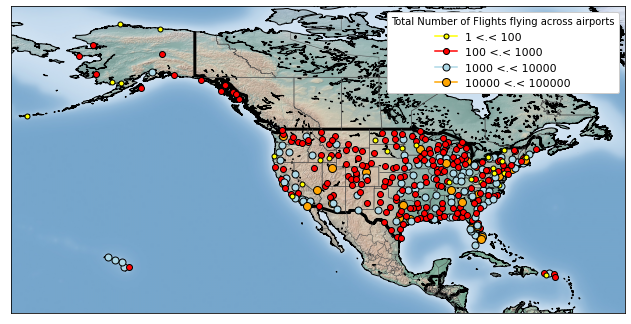

In [459]:
plt.figure(figsize=(11,11))
colors = ['yellow', 'red', 'lightblue', 'orange']
labels = []
size_limits = [1, 100, 1000, 10000, 100000]
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1])) 
    
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

for index, (code,y,x) in airports_df[['originairportcode', 'LATITUDE', 'LONGITUDE']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k',label = labels[ind])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000','10000 <.< 100000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Total Number of Flights flying across airports', frameon = True, framealpha = 1)
plt.show()

### *Phase 2: Cleaning the Dataset*

__2.1 Dates and times__
* From the flight data csv, we have 6 columns related to date - *YEAR, QUARTER, MONTH, DAYOFMONTH, DAYOFWEEK, and FLIGHTDATE*. I won't be using *YEAR and QUARTER* because the dataset is based on only the 4th quarter of the year 2021. So I will be removing these columns from the dataframe.

In [460]:
df_flights = df_flights.drop(columns=['year','quarter'])

* Additionally, in the *CRSDEPTIME* (Scheduled Departure time) variable, the hour and minute of the departure is coded as a float where the two first digits indicate the hour and the last two indicate the minutes. I convert this to HH:MM format using the datetime class because it is diffcult to work with. The following function format_time does this job:

In [461]:
# format_time accepts the floating point/integer values and returns a datetime object (HH:MM)
def format_time(time):
    if pd.isnull(time):
        return np.nan
    else:
        if time == 2400: time = 0
        time = "{0:04d}".format(int(time))
        hour_minute = datetime.time(int(time[0:2]), int(time[2:4]))
        return hour_minute

* I have applied the same function to *DEPTIME (actual departure time), CRSARRTIME (scehduled arrival time), and ARRTIME (actual arrival time)

In [462]:
df_flights['crsdeptime'] = df_flights['crsdeptime'].apply(format_time)
df_flights['deptime'] = df_flights['deptime'].apply(format_time)
df_flights['crsarrtime'] = df_flights['crsarrtime'].apply(format_time)
df_flights['arrtime'] = df_flights['arrtime'].apply(format_time)

* Note: The content of CRSDEPTIME (Scheduled departure time) and CRSARRTIME (scheduled arrival time) variables can be a bit misleading since they don't contain the dates. For example, in row 97229 of the dataframe, the scheduled departure is at 23h32 on 27nd, December. But due to unknown reasons there is a delay of 29 minutes. The DEPTIME (actual departure time) variable indicates 00h11 and we thus don't know if the flight left before time or if there was a large delay. Hence, the DEPDELAY and ARRDELAY variables proves more useful since they directly provides the delays in minutes.

__2.2 Dropping Null Columns__
* This step is fairly simple and straightforward. I have initialized a constant *NULL_THRESHOLD* with a value of 90. I use this constant to pick all the columns with a null_value_percentage greater than this. I remove all the columns that exceed this threshold. 

In [463]:
# Intializing a constant to remove columns that have a higher percentage of null values 
NULL_THRESHOLD = 90
flight_null_series = (df_flights.isnull().sum() / len(df_flights)) * 100
flight_null_series = pd.Series(flight_null_series).where(lambda x: x > NULL_THRESHOLD).dropna()
flight_null_series.index

Index(['cancellationcode', 'firstdeptime', 'totaladdgtime', 'longestaddgtime',
       'divreacheddest', 'divactualelapsedtime', 'divarrdelay', 'divdistance',
       'div1airport', 'div1airportid', 'div1airportseqid', 'div1wheelson',
       'div1totalgtime', 'div1longestgtime', 'div1wheelsoff', 'div1tailnum',
       'div2airport', 'div2airportid', 'div2airportseqid', 'div2wheelson',
       'div2totalgtime', 'div2longestgtime', 'div2wheelsoff', 'div2tailnum',
       'div3airport', 'div3airportid', 'div3airportseqid', 'div3wheelson',
       'div3totalgtime', 'div3longestgtime', 'div3wheelsoff', 'div3tailnum',
       'div4airport', 'div4airportid', 'div4airportseqid', 'div4wheelson',
       'div4totalgtime', 'div4longestgtime', 'div4wheelsoff', 'div4tailnum',
       'div5airport', 'div5airportid', 'div5airportseqid', 'div5wheelson',
       'div5totalgtime', 'div5longestgtime', 'div5wheelsoff', 'div5tailnum',
       'empty_col'],
      dtype='object')

In [464]:
df_flights = df_flights.drop(columns = flight_null_series.index.values.tolist())

* Filling the NA values corresponding to - *DEPDELAY, ARRDELAY, CARRIERDELAY, WEATHERDELAY, NASDELAY, SECURITYDELAY, LATEAIRCRAFTDELAY* with 0. I did this to have consistent data. Because the flights that have a delay due to one of the factors above, the rest of the parameters are set to 0. 

In [465]:
df_flights['carrierdelay'] = df_flights['carrierdelay'].fillna(0)
df_flights['weatherdelay'] = df_flights['weatherdelay'].fillna(0)
df_flights['nasdelay'] = df_flights['nasdelay'].fillna(0)
df_flights['securitydelay'] = df_flights['securitydelay'].fillna(0)
df_flights['lateaircraftdelay'] = df_flights['lateaircraftdelay'].fillna(0)
df_flights.depdelay = df_flights.depdelay.fillna(0)
df_flights.arrdelay = df_flights.arrdelay.fillna(0)

* Columns listed below will be dropped as we can't draw any useful insights from them. 

In [466]:
columns_to_remove = ['tail_number', 'origincitymarketid', 'originairportseqid', 'originstatefips', 'originwac',
                       'destairportseqid', 'destcitymarketid', 'deststatefips', 'destwac', 'depdelayminutes', 
                       'departuredelaygroups', 'deptimeblk', 'taxiout', 'wheelsoff', 'wheelson', 'taxiin', 
                       'arrdelayminutes', 'arrivaldelaygroups', 'arrtimeblk']
df_flights.drop(columns_to_remove, axis = 1, inplace = True)

### *Phase 3: Exploratory Analysis*

### __3.1 Comparing Airlines__

* I have created a airlines.csv with the reporting_airline code and the corresponding name of the airline 
* The output below shows the the total number of flights operated by each airline. It also gives us a picture of minimum_delay, maximum_delay, and average_delay encountered by each airline. 

In [467]:
airlines_names = pd.read_csv('airlines.csv')
airlines_names = airlines_names.set_index('IATA_CODE')
airlines_names_dict = airlines_names['AIRLINE'].to_dict()

In [468]:
#function get_details accepts a groupby object and returns a dictionary with the details of each airline 
def get_details(group):
    return {'flight_count': group.count(), 'min_delay': group.min(), 'max_delay': group.max(), 'avg_delay': group.mean()}

grouped_departure_delay_by_airline = df_flights['depdelay'].groupby(df_flights['reporting_airline'])
df_airline_stats = grouped_departure_delay_by_airline.apply(get_details).unstack()
df_airline_stats

,flight_count,min_delay,max_delay,avg_delay
reporting_airline,,,,
9E,43025.0,-27.0,1260.0,2.890296
AA,144732.0,-40.0,3001.0,9.498197
AS,33778.0,-45.0,844.0,10.327077
B6,40806.0,-37.0,1834.0,14.878400
DL,138898.0,-60.0,1227.0,8.431215
F9,25963.0,-37.0,1335.0,13.668605
G4,19338.0,-34.0,859.0,15.499121
HA,11955.0,-19.0,1462.0,5.736763
MQ,45171.0,-25.0,1557.0,4.693343


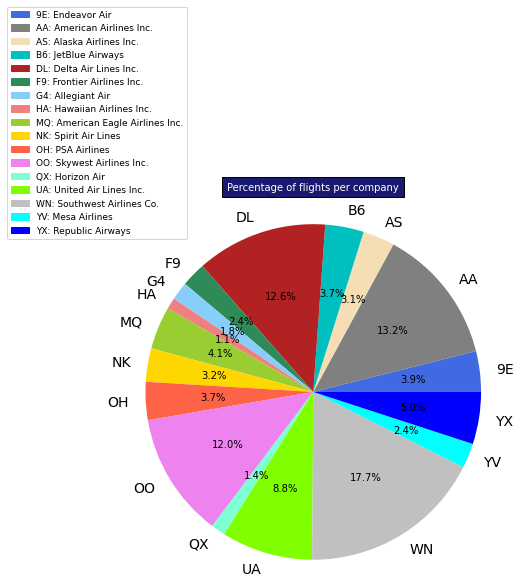

In [473]:
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse', 'silver', 'cyan', 'blue']
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
labels = [s for s in  df_airline_stats.index]
sizes  = df_airline_stats['flight_count'].values
patches, texts, autotexts = ax1.pie(sizes, labels = labels, shadow=False, autopct='%1.1f%%', colors=colors, radius=2)
for i in range(len(airlines_names_dict)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('Percentage of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=10, pad=16)

legend_list = []
for i in range(len(airlines_names_dict)):
    legend_list.append(mpatches.Patch(color=colors[i],
            label = df_airline_stats.index[i] + ': ' + airlines_names_dict[df_airline_stats.index[i]]))
ax1.legend(handles=legend_list, bbox_to_anchor=(0.2, 0.9), fontsize = 9)
ax1.axis('equal')

plt.show() 

### __3.2 Visualizing Departure and Arrival Delays__

depdelay 
Minimum:-60.00
Mean:10.34
Median:-1.00
Mode:-5.00
Maximum:3001.00

arrdelay 
Minimum:-82.00
Mean:3.69
Median:-6.00
Mode:0.00
Maximum:2976.00



C:\Users\chanh\AppData\Local\Temp/ipykernel_20204/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chanh\AppData\Local\Temp/ipykernel_20204/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


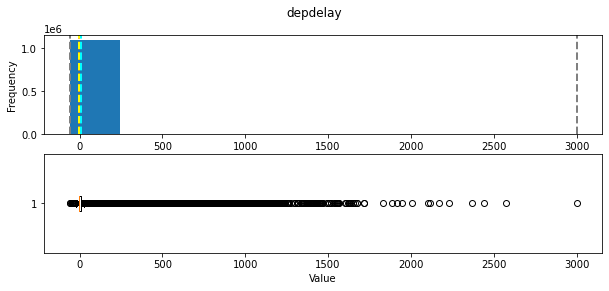

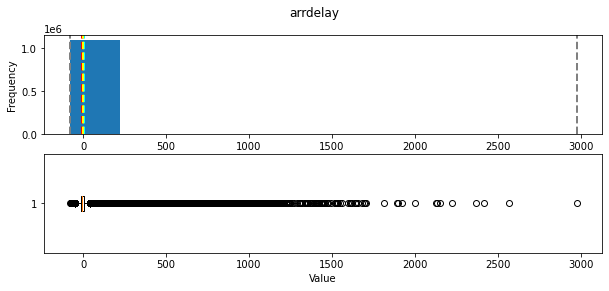

In [474]:
# show_distribution lists the summary stats and distribution for the columns - depdelay and arrdelay
def show_distribution(var_data):

    # Get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]

    print(var_data.name,'\nMinimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    # Create a figure for 2 subplots (2 rows, 1 column)
    fig, ax = plt.subplots(2, 1, figsize = (10,4))

    # Plot the histogram   
    ax[0].hist(var_data)
    ax[0].set_ylabel('Frequency')

    # Add lines for the mean, median, and mode
    ax[0].axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2)
    ax[0].axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2)

    # Plot the boxplot   
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')

    # Add a title to the Figure
    fig.suptitle(var_data.name)

    # Show the figure
    fig.show()

# Call the function for each delay field
delayFields = ['depdelay','arrdelay']
for col in delayFields:
    show_distribution(df_flights[col])

There are a outliers at the lower and upper ends of both variables - particularly at the upper end.

Let's trim the data so that we include only rows where the values for these fields are within the 1st and 90th percentile.

depdelay 
Minimum:-12.00
Mean:-1.71
Median:-3.00
Mode:-5.00
Maximum:15.00

arrdelay 
Minimum:-37.00
Mean:-8.39
Median:-9.00
Mode:0.00
Maximum:32.00



C:\Users\chanh\AppData\Local\Temp/ipykernel_20204/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chanh\AppData\Local\Temp/ipykernel_20204/1381439888.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


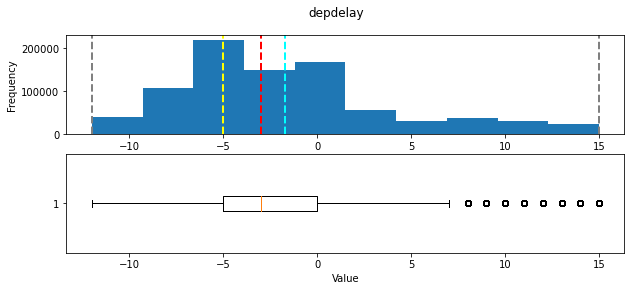

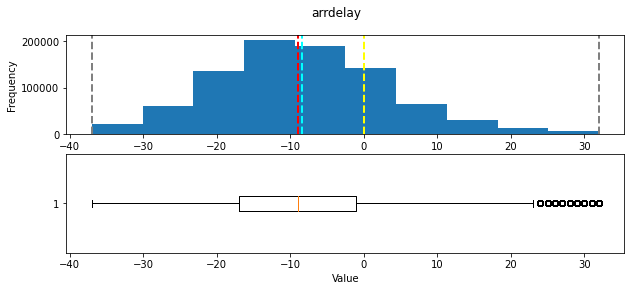

In [475]:
df_flights_copy = df_flights.copy()
# Trim outliers for arrdelay based on 1% and 90% percentiles
df_flights_copy = df_flights_copy[df_flights_copy.arrdelay < df_flights_copy.arrdelay.quantile(0.90)]
df_flights_copy = df_flights_copy[df_flights_copy.arrdelay > df_flights_copy.arrdelay.quantile(0.01)]

# Trim outliers for depdelay based on 1% and 90% percentiles
df_flights_copy = df_flights_copy[df_flights_copy.depdelay < df_flights_copy.depdelay.quantile(0.90)]
df_flights_copy = df_flights_copy[df_flights_copy.depdelay > df_flights_copy.depdelay.quantile(0.01)]

# View the revised distributions
for col in delayFields:
    show_distribution(df_flights_copy[col])

From the above departure delay histogram, results show that:
* approximately 585,000 flights experience a departure delay between -12.5min and 0min (early departure) 
* approximately 273,000 flights experience a departure delay between 0min and 15min (late departure)
* approximately 203,000 flights experience a departure delay above 15mins. These flights have been delayed due to reasons such as weatherdelay, carrierdelay, nasdelay or securitydelay. I will discuss this in upcoming sections.

<br>From the above arrival delay histogram, results show that:
* approximately 651,000 flights experience an arrival delay between -40min and 0min (early arrival) 
* approximately 212,000 flights experience an arrival delay between 0min and 30min (late arrival)
* approximately 118,000 flights experience an arrival delay above 30mins. These flights have been delayed due to reasons such as weatherdelay, carrierdelay, nasdelay or securitydelay. I will discuss this in upcoming sections.

In [476]:
#df_flights_copy[(df_flights_copy['depdelay']>=0) & (df_flights_copy['depdelay']<15)]

For the purpose of convenience, I add the airport_name and airline_name to df_flights dataframe

In [477]:
def set_airport_name(row):
    if row['origin'] in airports.keys():
        return airports[row['origin']]['name']

def set_airline_name(row):
    if row['reporting_airline'] in airlines_names_dict.keys():
        return airlines_names_dict[row['reporting_airline']]
    
df_flights['originairportname'] = df_flights.apply(lambda row: set_airport_name(row), axis=1)
df_flights['airlinename'] = df_flights.apply(lambda row: set_airline_name(row), axis=1)

<AxesSubplot:xlabel='originairportname', ylabel='Mean Delay in Minutes'>

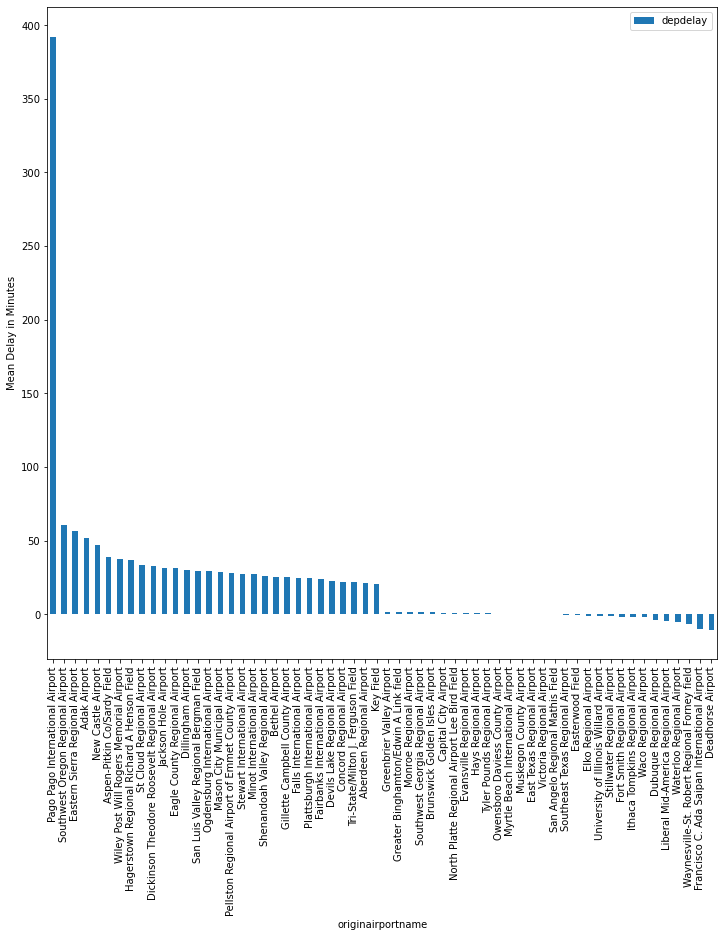

In [485]:
departure_airport_group = df_flights.groupby(df_flights.originairportname)

mean_departure_delays = pd.DataFrame(departure_airport_group['depdelay'].mean()).sort_values('depdelay', ascending=False)
large_delay_df = mean_departure_delays[0:30].copy()
small_delay_df = mean_departure_delays[-30:].copy()
frames = [large_delay_df, small_delay_df]
mean_depdelay = pd.concat(frames)
mean_depdelay.plot(kind = "bar", figsize=(12,12), ylabel="Mean Delay in Minutes")

* There are about 352 unique airports in the given dataset. I have only extracted 60 airports with their mean departure delay values, the first 30 in descending order of mean and the last 30 in ascending order of mean. This is just to make the visualization easier.
* Pago Pago International Airport seems to have the highest average departure delay compared to the rest of the airports. It has an average departure of delay of approximately 390min. On going through the dataset, Pago Pago International Airport has had only 3 departures, of which one of the departures had been delayed by 1037 minutes. This was due to carrier delay. All 3 flights that departed from Pago Pago International airport suffered a departure delay of atleast 50min. This is a misleading metric while visualizing departure delays specific to airports.

In [ ]:
mean_arrival_delays = pd.DataFrame(departure_airport_group['arrdelay'].mean()).sort_values('arrdelay', ascending=False)
large_delay_df = mean_departure_delays[0:30].copy()
small_delay_df = mean_departure_delays[-30:].copy()
frames = [large_delay_df, small_delay_df]
mean_depdelay = pd.concat(frames)
mean_depdelay.plot(kind = "bar", figsize=(12,12), ylabel="Mean Delay in Minutes")